# Retail sales forecasting

# About Dataset:
## Context
This dataset contains lot of historical sales data. It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer.

### Content
[TBD]

### Acknowledgements
This data would not be available without the full collaboration from our customers who understand that sharing their core and strategical information has more advantages than possible hazards. They also support our continuos development of innovative ML systems across their value chain.

### Inspiration
Every retail business in the world faces a fundamental question: how much inventory should I carry? In one hand to mush inventory means working capital costs, operational costs and a complex operation. On the other hand lack of inventory leads to lost sales, unhappy customers and a damaged brand.

Current inventory management models have many solutions to place the correct order, but they are all based in a single unknown factor: the demand for the next periods.

This is why short-term forecasting is so important in retail and consumer goods industry.

We encourage you to seek for the best demand forecasting model for the next 2-3 weeks. This valuable insight can help many supply chain practitioners to correctly manage their inventory levels.

# Import packages and set enviroment:

In [1]:
#Import packages

import gc
import re
from collections import defaultdict
from typing import Tuple, Optional, List, NamedTuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
#import tensorflow_decision_forests as tfdf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
import pydot
from IPython.display import Image

plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 3)

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
EXECUTION_MODE = "MINI"
# Here you can see the available config and their parameter values.
#
# num_trees: Number of decision trees trained in each model.
# num_items / num_stores: Number of selected items /stores in the dataset.
# num_horizons: How many steps to forecast in multi-step forecast.

available_configs = {
    "TOY": {
        "num_trees": 20,
        "num_items": 3,
        "num_stores": 3,
        "num_horizons": 2,
    },
    "MINI": {
        "num_trees": 75,
        "num_items": 5,
        "num_stores": 5,
        "num_horizons": 7,
    },
    "FULL": {
        "num_trees": 1000,
        "num_items": None,
        "num_stores": None,
        "num_horizons": 28,
    }
}

config = available_configs[EXECUTION_MODE]
print(f"{config=}")

config={'num_trees': 75, 'num_items': 5, 'num_stores': 5, 'num_horizons': 7}


# Load data and do some EDA:

In [3]:
# load sales data
raw_sales = pd.read_csv(
    r'C:\Users\andre\Desktop\Scripts\DATASETS\CSV\Retail Sales Forecasting\mock_kaggle.csv'
)

raw_sales.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [4]:
raw_sales.columns = ['DATE', 'SALES', 'STOCKS', 'PRICE']

raw_sales.head()


,DATE,SALES,STOCKS,PRICE
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [5]:
max_date = raw_sales['DATE'].max()
min_date = raw_sales['DATE'].min()

print(min_date, max_date)

2014-01-01 2016-07-31


<Axes: >

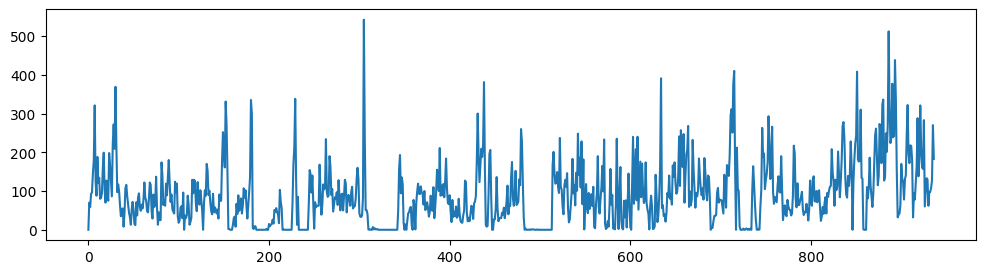

In [6]:
#@title
# plot the sum of all the sales over the last 2 months.
# sales = raw_sales['SALES'].sum().squeeze().astype(float)
sales = raw_sales['SALES'].squeeze().astype(int)
sales.plot.line()


<Axes: >

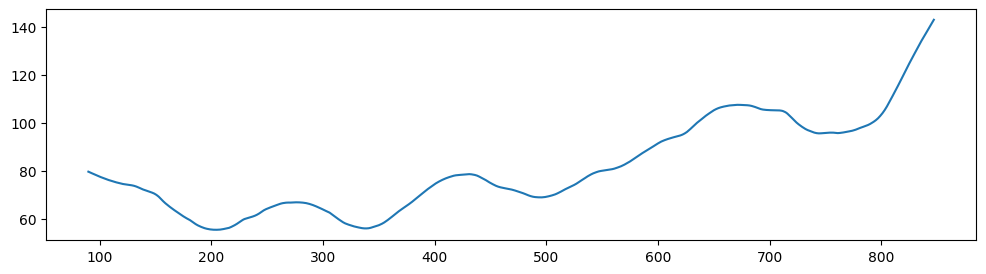

In [7]:
sales.rolling(180, center=True, win_type="triang").mean().plot.line()

# Time to forecast!

# Findig the right parameters:
One way to find the best values for the order and seasonal_order parameters is to use a grid search. This involves fitting a SARIMA model for different combinations of the parameters and choosing the combination that results in the best model fit.

The p, d, and q parameters in a SARIMA model represent the order of the autoregressive (AR), differencing (I), and moving average (MA) terms, respectively. The values of these parameters determine the complexity of the model.

In the example code I provided, I chose to let p, d, and q take any value between 0 and 2 as a starting point for the grid search. This means that the grid search will consider SARIMA models with AR, I, and MA terms of order 0, 1, or 2. This range of values is often a good starting point for time series forecasting problems.

However, depending on your data and the specific problem you’re trying to solve, you may need to consider a wider range of values for these parameters. You can adjust the range of values for p, d, and q in the grid search to find the best model for our data.

Here’s an example of how you might do this:

In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# # Make sure the DATE column is in datetime format
# raw_sales['DATE'] = pd.to_datetime(raw_sales['DATE'])

# # Set the DATE column as the index
# raw_sales.set_index('DATE', inplace=True)

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(raw_sales['SALES'], order=param, seasonal_order=param_seasonal)
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                
        except:
            continue

print(f'Best SARIMA model: {best_pdq} x {best_seasonal_pdq} with AIC={best_aic}')


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been pro

Best SARIMA model: (1, 2, 1) x (2, 2, 2, 12) with AIC=14.0


This code will fit a SARIMA model for each combination of order and seasonal_order parameters and choose the combination that results in the lowest AIC value. The AIC (Akaike Information Criterion) is a measure of how well the model fits the data while penalizing models with more parameters to avoid overfitting.

In [12]:
p, d, q = 1, 2, 1
P, D, Q, s = 2, 2, 2, 12

# # Make sure the DATE column is in datetime format
# raw_sales['DATE'] = pd.to_datetime(raw_sales['DATE'])

# # Set the DATE column as the index
# raw_sales.set_index('DATE', inplace=True)

# Fit a SARIMA model to the data
model = SARIMAX(
    raw_sales['SALES'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s)
)
results = model.fit()

# Forecast sales for the next year
forecast = results.get_forecast(steps=12)


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction 